In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,           RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler,                                       MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor,                                                   GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

#### Datasets

In [51]:
import os
for dirname, _, filenames in list(os.walk('./input/'))[1:2]:
    TRAIN_DATASET_PATH = os.path.join(dirname, filenames[3]).replace("\\","/")
    TEST_DATASET_PATH = os.path.join(dirname, filenames[2]).replace("\\","/")
    SUBMIT = os.path.join(dirname, filenames[1]).replace("\\","/")
        
TRAIN_DATASET_PATH, TEST_DATASET_PATH, SUBMIT 

('./input/real_estate_price_prediction_moscow/rf_submit1_2.csv',
 './input/real_estate_price_prediction_moscow/rf_submit11.csv',
 './input/real_estate_price_prediction_moscow/rf_submit.csv')

In [52]:
    TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
    TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'
    SUBMIT = './input/real_estate_price_prediction_moscow/submit.csv'

#### Auxiliary functions

In [53]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [54]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [55]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [56]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [57]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

#### Target distribution

In [58]:
train_df.head(3)
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


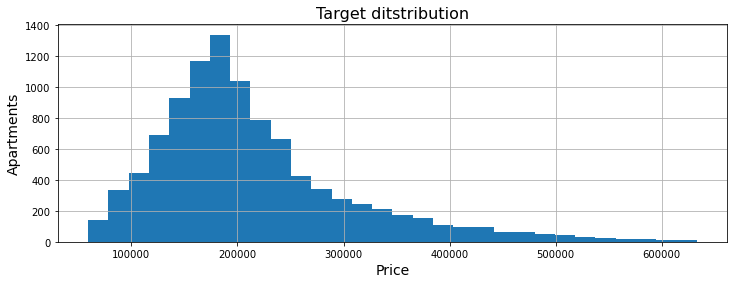

In [59]:
plt.figure(figsize=(12, 4))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Apartments', fontsize=14)
plt.title('Target ditstribution', fontsize=16)

plt.show()

#### Correlation

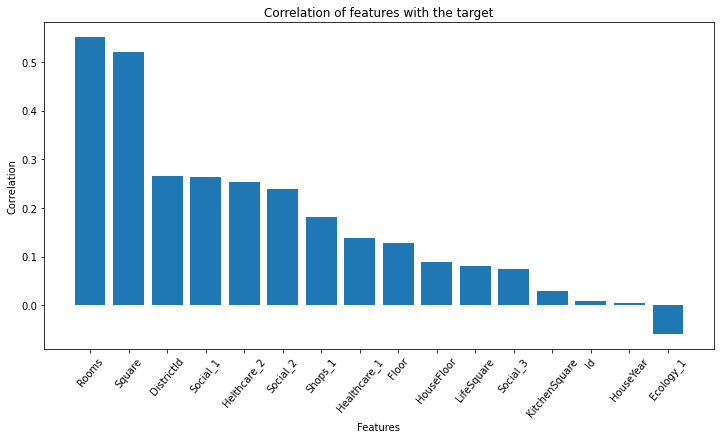

In [60]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

In [61]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [62]:
# KitchenSquare min and max
min_kitchen_square = np.quantile(train_df['KitchenSquare'], q=0.001)
max_kitchen_square = np.quantile(train_df['KitchenSquare'], q=0.999)
print(min_kitchen_square, max_kitchen_square)

0.0 72.0010000000002


In [63]:
train_df['Floor'].max()

42

In [64]:
z = train_df.groupby('DistrictId')['Healthcare_1'].mean().to_dict()
z[2]

1435.2542724609375

In [65]:
train_df['Rooms'].isna().sum()

0

In [66]:
medians = train_df.median()
np.round(medians['LifeSquare'] / medians['Rooms'], 1)

16.4

In [67]:
train_df[train_df['Square'] < train_df['KitchenSquare']] ###!!!!!!!!

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2785,6569,27,1.0,38.220257,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
5273,13703,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
6505,14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


In [68]:
train_df[train_df['Square'] < train_df['LifeSquare']].shape

(482, 20)

In [69]:
train_df['Square'], train_df['KitchenSquare'] = np.where(
    train_df['Square'] < train_df['KitchenSquare'],
             (train_df['KitchenSquare'], train_df['Square']), (train_df['Square'], train_df['KitchenSquare'])
)

In [70]:
train_df.replace({'Ecology_2': {'A': 0, 'B': 1}, 'Ecology_3': {'A': 0, 'B': 1}, 'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

In [71]:
train_df[train_df['HouseFloor'] < train_df['Floor']].shape

(1825, 20)

#### ~ class DataPreprocessing

In [72]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians = None
        self.max_square = None
        self.min_kitchen_square = None
        self.max_kitchen_square = None
        self.min_life_square = None
        self.max_floor = None
        self.districts_healthcare = None
        self.min_floor = None

    
    def fit(self, X):
        # Medians and quantiles
        self.medians = X.median()
        self.min_kitchen_square = np.quantile(X['KitchenSquare'], q=0.001)
        self.max_kitchen_square = np.quantile(X['KitchenSquare'], q=0.999)
        self.min_life_square = np.quantile(X['LifeSquare'], q=0.03)
        self.max_floor = X['Floor'].max()
        self.min_floor = 1
        
        # healthcare in each district
        self.mean_h1_district = X.groupby('DistrictId')['Healthcare_1'].mean().to_dict()
        
        
    def transform(self, X):
        # Fill columns
        
        # LifeSquare
        X['LifeSquare'].fillna(X['Square'] * .9 - X['KitchenSquare'], inplace=True)

        
        # Rooms
        condition_rooms = (X['Rooms'] >= 6) | (X['Rooms'] == 0)
        room_square_median = self.medians['LifeSquare'] / self.medians['Rooms']
        X.loc[condition_rooms, 'Rooms'] = X.loc[condition_rooms, 'LifeSquare'] / room_square_median
        

        # Square

        # Square < KitchenSquare --> Square <=> KitchenSquare (if KitchenSquare <= 250 (--> for Square this max))
        X['Square'], X['KitchenSquare'] = np.where(
            (X['Square'] <= X['KitchenSquare']) & (X['KitchenSquare'] <= 250),
            (X['KitchenSquare'], X['Square']), (X['Square'], X['KitchenSquare'])
        )

        # Square < LifeSquare --> Square <=> LifeSquare 
        X['Square'], X['LifeSquare'] = np.where(
            X['Square'] < X['LifeSquare'], (X['LifeSquare'], X['Square']), (X['Square'], X['LifeSquare'])
        )
        
        
        # KitchenSquare
        # Outliers --> Square - LifeSquare - 3
        condition_kitchen_square = (X['KitchenSquare'] > 60) | (X['KitchenSquare'] < self.min_kitchen_square)

        X.loc[condition_kitchen_square, 'KitchenSquare'] = \
        X.loc[condition_kitchen_square, 'Square'] - X.loc[condition_kitchen_square, 'LifeSquare'] - 3
        
        
        # Ecology and Shops
        # Switch to binary
        X.replace({
            'Ecology_2': {'A': 0, 'B': 1},
            'Ecology_3': {'A': 0, 'B': 1},
            'Shops_2': {'A': 0, 'B': 1}
        }, inplace=True)
        
        
        # Floor
        # Min Floor
        train_df.loc[train_df['Floor'] < self.min_floor, 'Floor'] = self.min_floor
        
        
        # HouseFloor
        # HouseFloor < Floor --> HouseFloor = Floor
        condition_house_floor = X['HouseFloor'] < X['Floor'] 
        X.loc[condition_house_floor, 'HouseFloor'] = X.loc[condition_house_floor, 'Floor']
        
        # HouseYear
        # HouseYear > current year --> median year
        current_year = datetime.now().year
        condition_year = X['HouseYear'] > current_year
        X.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        
        # Healthcare
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.mean_h1_district)
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        q_max = np.quantile(X['Healthcare_1'], q=0.9)
        X['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        # Id remove
        X.drop(columns=['Id'], inplace=True)
        
        # Fillna
        X.fillna(self.medians, inplace=True)

        return X

### 4. Building new features 

In [73]:
class FeatureGenerator:
    """Generation of new features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_min = None
        self.floor_max = None
        self.house_year_min = None
        self.house_year_max = None
        self.district_size = None
        self.mean_square_rooms = None
        
    
    def fit(self, X, y=None):
        
        X = X.copy()

        # DistrictId
        self.district_size = X['DistrictId'].value_counts()\
        .reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## Floor, HouseYear
        if y is not None:
            self.floor_min = df['Floor'].min()
            self.floor_max = df['Floor'].max()
            self.house_year_min = df['HouseYear'].min()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByFloorYear'})
            
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            
    def transform(self, X):
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on=['DistrictId'], how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # MeanLifeSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'LifeSquare']].sum()
        
        self.mean_square_rooms['MeanLifeSquareRooms'] = \
        (self.mean_square_rooms['LifeSquare'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'LifeSquare'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        # MeanSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'Square']].sum()
        
        self.mean_square_rooms['MeanSquareRooms'] = \
        (self.mean_square_rooms['Square'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'Square'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        # More Categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        #target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return X
    
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], include_lowest=True, bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X
    
    
    def year_to_cat(self, X):
        bins= [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X
    
    

### 5. Feature selection

In [74]:
feature_names = [
    'Social_2',
    'Social_1',
    'Social_3',
    'Healthcare_1',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_2'
]

#, 'Rooms', 'Healthcare_2','Social_1', 'Social_2', 'Social_3', 'Shops_2', 'Shops_1', 'Ecology_1', 'Ecology_2', 'Ecology_3'
#'Rooms',

new_feature_names = [
    'MedPriceByDistrict',
    'MedPriceByFloorYear',
    'MeanLifeSquareRooms',
    #'MeanSquareRooms',
    'DistrictSize',
    'IsDistrictLarge'
]

#'Rooms_outlier', 'MedPriceByFloorYear', 'DistrictSize', 'IsDistrictLarge', 'Rooms_outlier',  'MedPriceByDistrict', 

target_name = 'Price'

### 6. Splitting into train / test

In [75]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, shuffle=True, random_state=21)

In [77]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 18), (2000, 18), (5000, 18))

In [78]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [79]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 27), (2000, 27), (5000, 27))

In [80]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [81]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

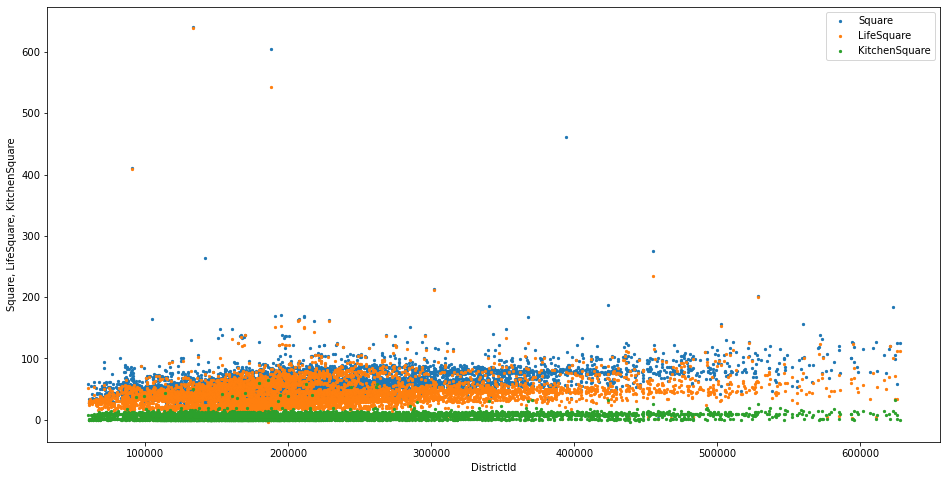

In [82]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare']

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(y_train, X_train[feature], label=feature, s=5)

plt.xlabel('DistrictId')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

### 7. Building a model

In [83]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)

In [84]:
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [85]:
#cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
#cv_score

In [86]:
#cv_score.mean()

In [87]:
#feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
#feature_importances.sort_values(by='importance', ascending=False)

In [88]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [89]:
# rf_model = RandomForestRegressor(
#     criterion='mse',
#     max_depth=20,  # глубина дерева
#     min_samples_leaf=2,  # минимальное количество наблюдений в листе дерева
#     random_state=42,
#     n_estimators=550  # количество деревьев
# )

# rf_model.fit(X_train, y_train)

# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
#0.941, 0.728

Train R2:	0.9166
Test R2:	0.7386


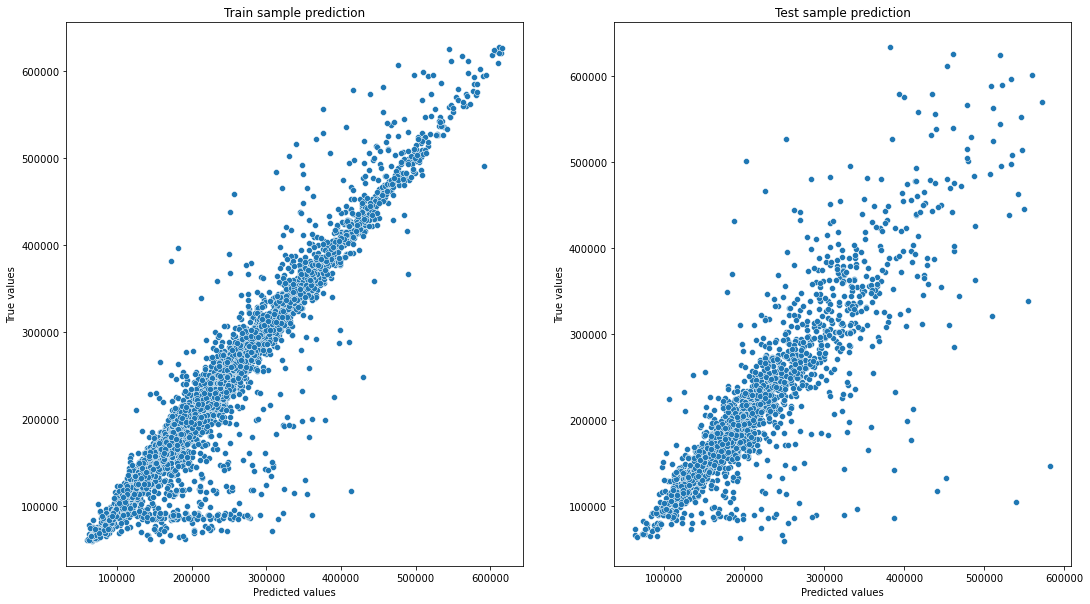

In [90]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=1500, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.126)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [91]:
# gb_model = GradientBoostingRegressor(
#     criterion='mse',
#     max_depth=5,
#     min_samples_leaf=7,
#     random_state=42,
#     n_estimators=350
# )

# gb_model.fit(X_train, y_train)

# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
# #0.88 0.727

### 8. Prediction on test dataset

In [92]:
test_df.shape

(5000, 16)

In [93]:
submit = pd.read_csv('./input/real_estate_price_prediction_moscow/sample_submission.csv')

In [94]:
predictions = gb_model.predict(test_df)
predictions

array([165510.44628374, 140592.04891271, 135258.33742348, ...,
       149253.86217908, 184140.26204729, 306405.17893483])

In [95]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165510.446284
1,5925,140592.048913
2,960,135258.337423
3,3848,106266.045811
4,746,189052.547231


In [96]:
submit.to_csv('./input/real_estate_price_prediction_moscow/gb_submit.csv', index=False)